In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

'/home/nils/projects/uq-regression-box'

In [2]:
from uq_regression_box.datamodules import ToySineDatamodule
from uq_regression_box.models import MLP
from uq_regression_box.uq_methods import (
    BaseModel,
    CQR,
    MCDropoutModel,
    QuantileRegressionModel,
    LaplaceModel,
    DeepEnsembleModel
)

import matplotlib.pyplot as plt
import torch
import numpy as np

from uq_regression_box.viz_utils import (
    plot_toy_data,
    plot_predictions,
    plot_calibration_uq_toolbox,
)

from uq_regression_box.train_utils import basic_train_loop, NLL, QuantileLoss

from uq_regression_box.eval_utils import compute_empirical_coverage

%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["figure.figsize"] = [28, 9]

In [4]:
dm = ToySineDatamodule()
X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

X_test_cpu = torch.clone(X_test).numpy()
y_test_cpu = torch.clone(y_test).numpy()

# Base Model

In [5]:
config = {
    "model": {
        "model_name": "mlp",
    },
    "optimizer": {"lr": 1e-2},
}
base_model = BaseModel(config, MLP())

In [6]:
base_model = basic_train_loop(
    base_model,
    torch.nn.MSELoss(),
    train_loader,
    config["optimizer"]["lr"],
    n_epochs=1000,
)

100%|██████████| 1000/1000 [00:06<00:00, 143.57it/s, loss=0.09656824171543121]


In [7]:
# get predictions
with torch.no_grad():
    y_preds_det = base_model(X_test)

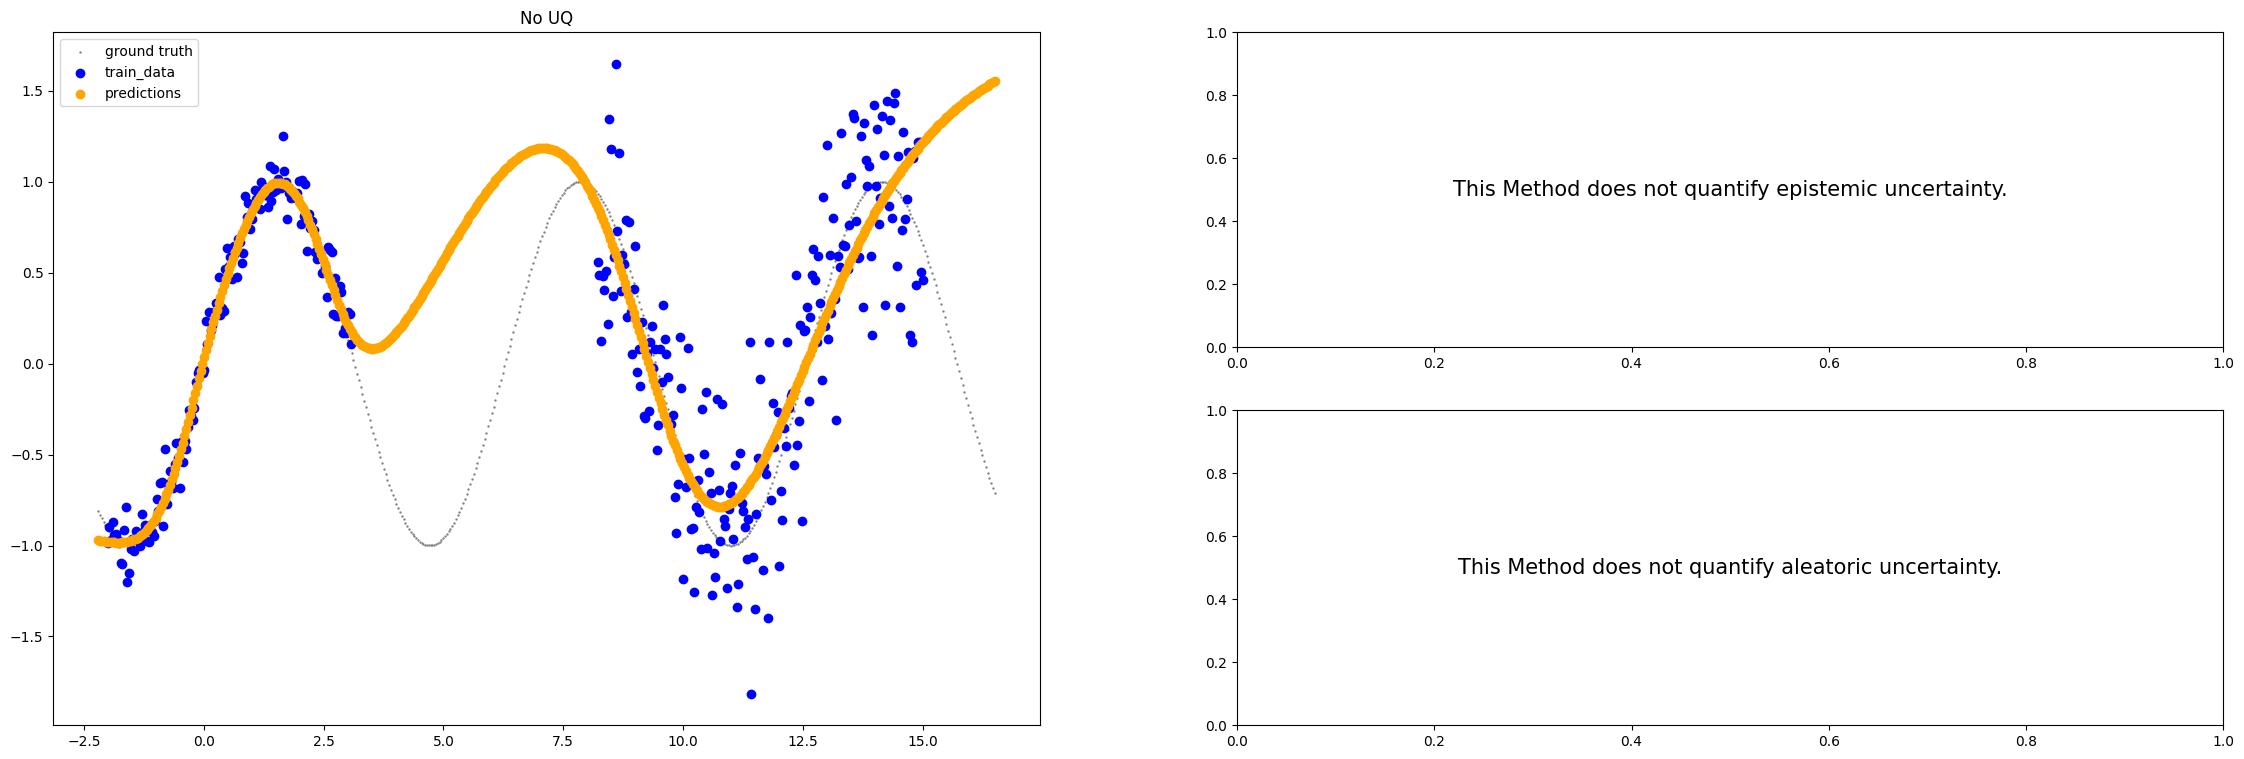

In [9]:
# plot predictions
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, y_preds_det, title="No UQ")

# MC Dropout

In [9]:
config = {
    "model": {"model_name": "mlp", "mc-samples": 20},
    "optimizer": {"lr": 1e-2},
}
mc_droput_model = MCDropoutModel(
    config,
    MLP(n_outputs=2, dropout_p=0.1, n_hidden=[50, 50, 50], predict_sigma=True),
)

# train_model
basic_train_loop(mc_droput_model, NLL(), train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    out = mc_droput_model.predict_step(X_test, y_test)
    mc_mean_nll = out["mean"]
    mc_std_nll = out["pred_uct"]
    mc_epistemic = out["epistemic_uct"]
    mc_aleatoric = out["aleatoric_uct"]

100%|██████████| 1000/1000 [00:08<00:00, 112.97it/s, loss=-1.5953792333602905]


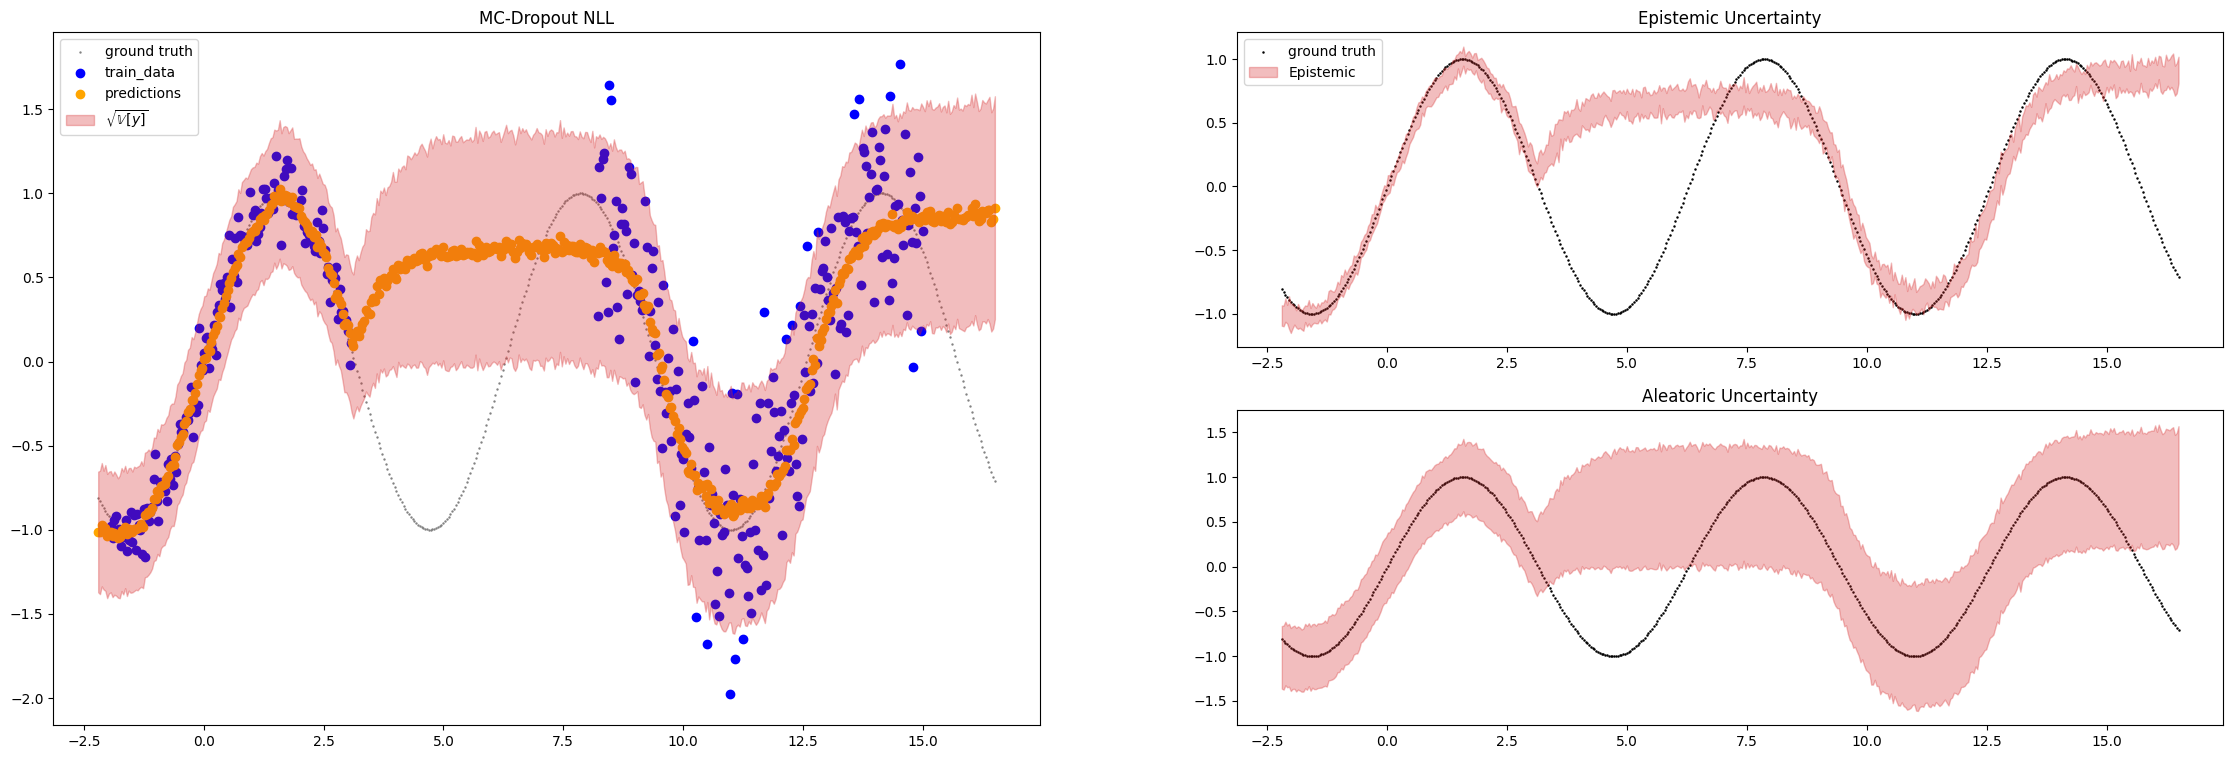

<Figure size 2800x900 with 0 Axes>

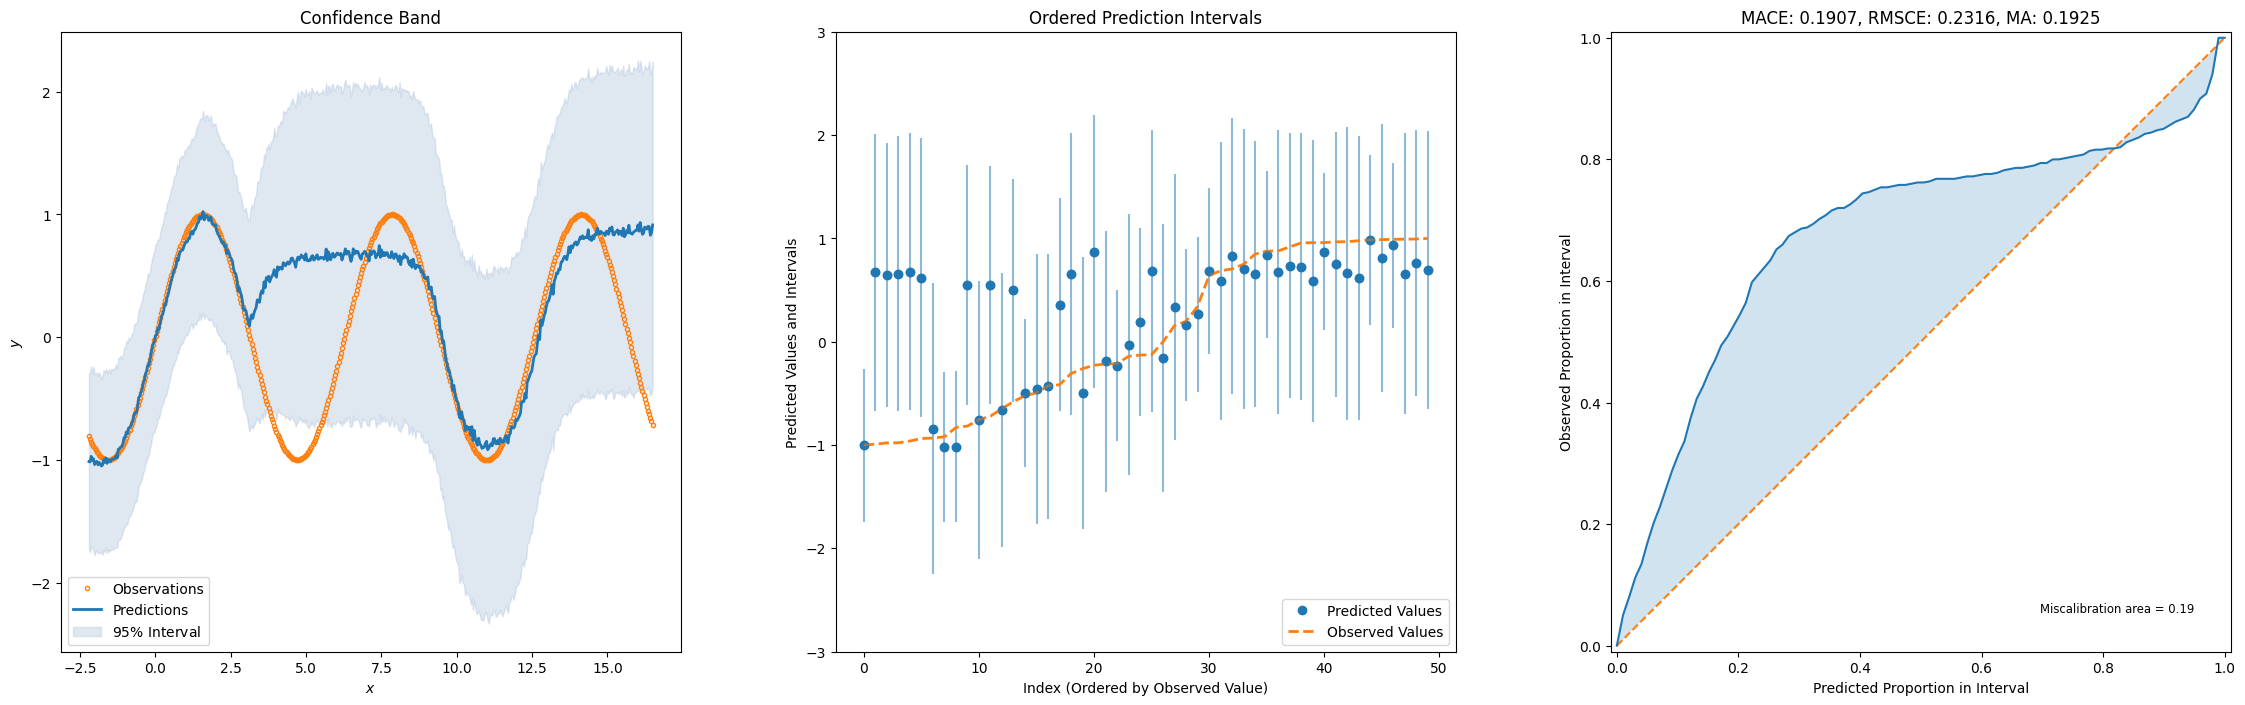

In [10]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mc_mean_nll,
    mc_std_nll,
    epistemic=mc_epistemic,
    aleatoric=mc_aleatoric,
    title="MC-Dropout NLL",
)
plot_calibration_uq_toolbox(mc_mean_nll, mc_std_nll, y_test_cpu, X_test_cpu)

# Quantile Regression

In [11]:
quantiles = [0.1, 0.5, 0.9]
config = {
    "model": {"model_name": "mlp", "quantiles": quantiles},
    "optimizer": {"lr": 1e-2},
}

In [12]:
qr_model = QuantileRegressionModel(
    config, MLP(n_outputs=len(quantiles), n_hidden=[50, 50, 50])
)

# train_model
basic_train_loop(qr_model, qr_model.criterion, train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    out = qr_model.predict_step(X_test, y_test)
    qr_mean = out["mean"]
    qr_median = out["median"]
    qr_std = out["pred_uct"]
    qr_aleatoric = out["aleatoric_uct"]
    quantile_preds = np.stack(
        [out["lower_quant"], qr_mean, out["upper_quant"]], axis=-1
    )

100%|██████████| 1000/1000 [00:08<00:00, 115.48it/s, loss=0.0654098391532898]


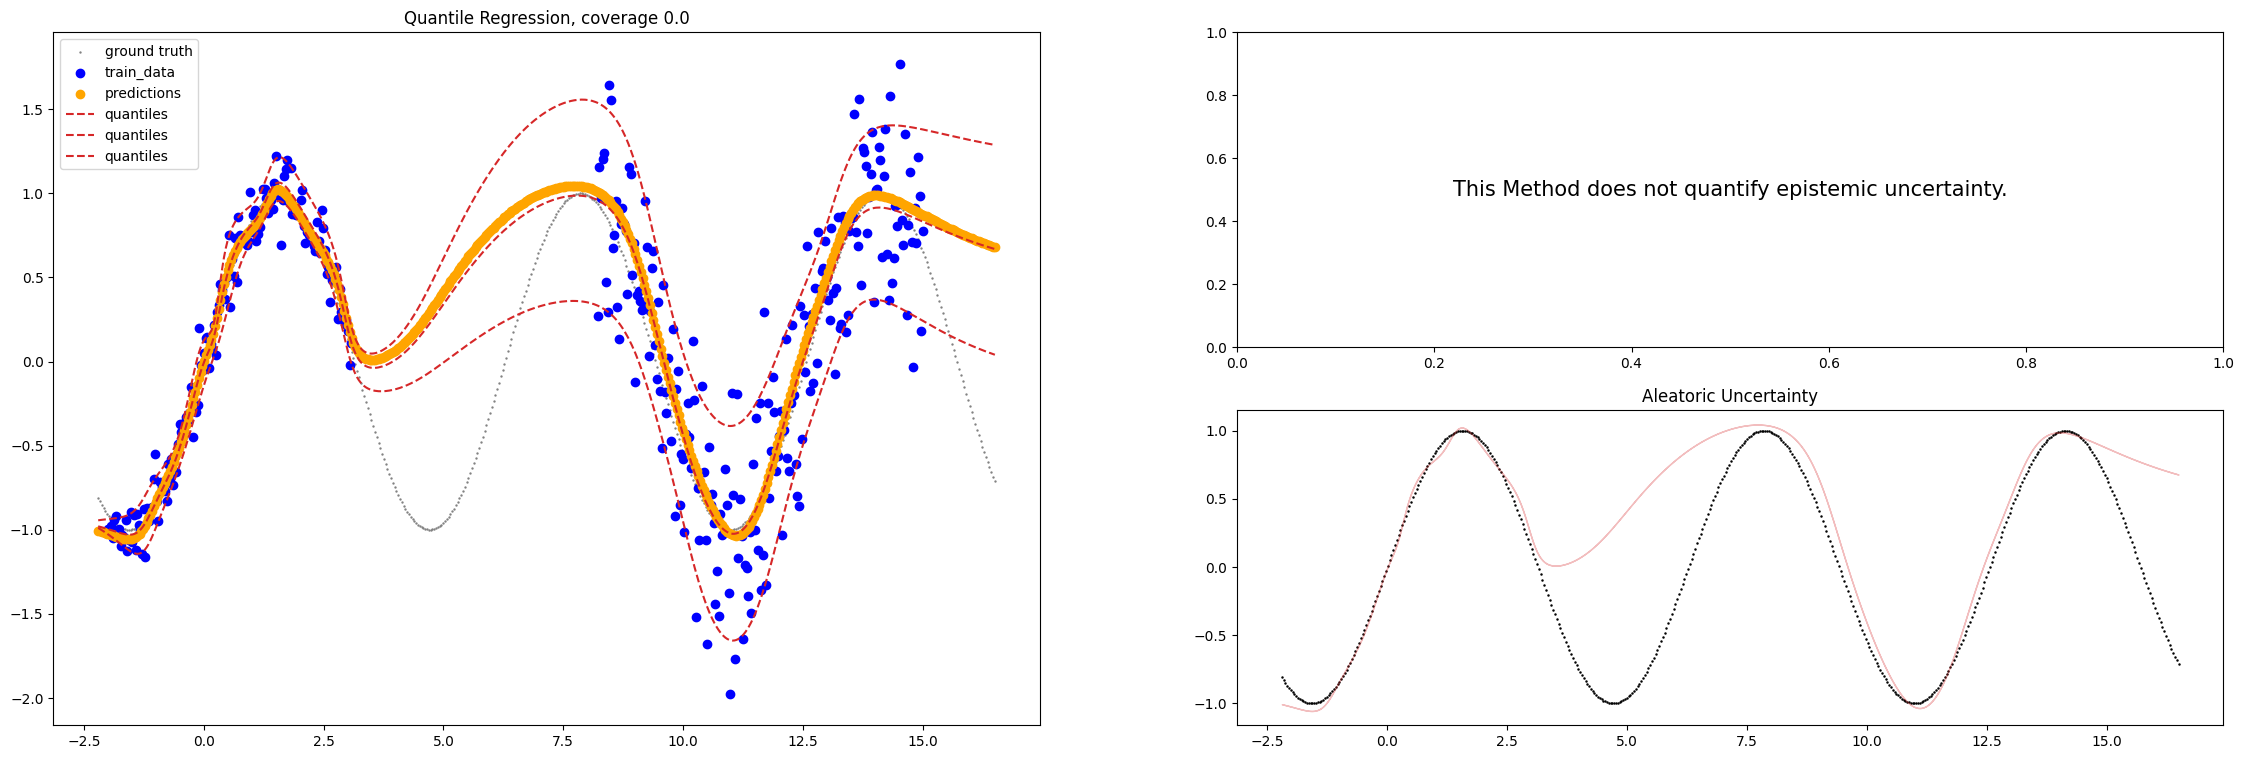

<Figure size 2800x900 with 0 Axes>

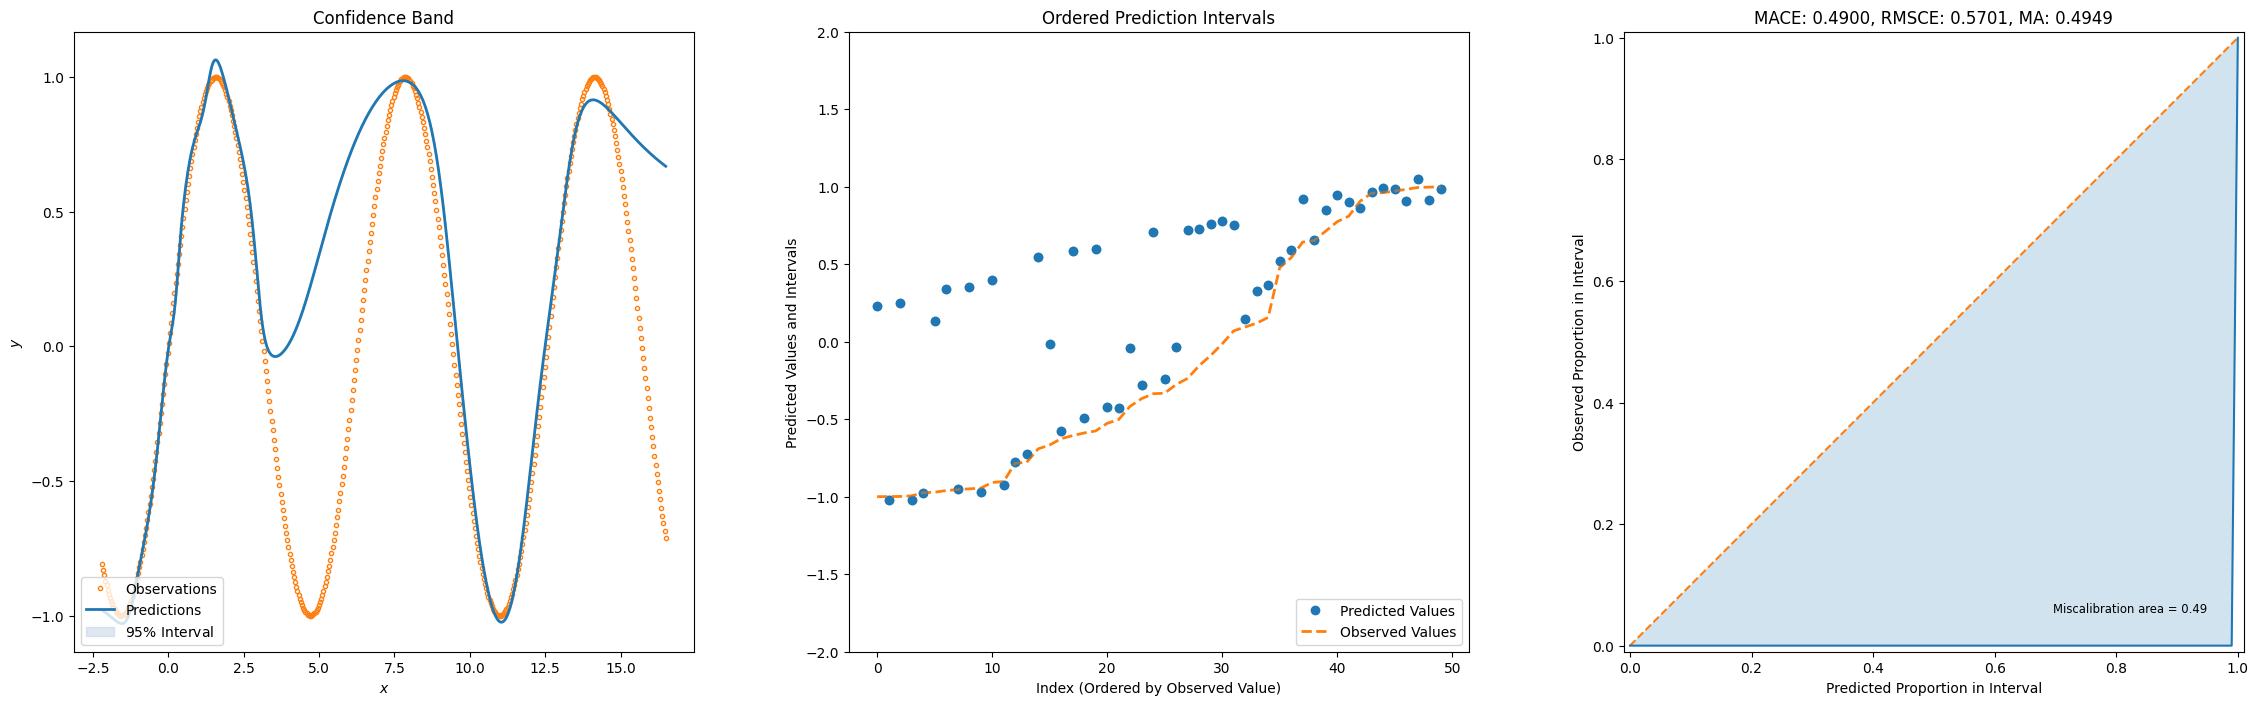

In [13]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    qr_median,
    pred_quantiles=quantile_preds,
    aleatoric=qr_aleatoric,
    title=f"Quantile Regression, coverage {compute_empirical_coverage(quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(qr_mean, qr_std, y_test_cpu, X_test_cpu)

# Conformalize Quantile Regression

In [14]:
cqr = CQR(qr_model.model, quantiles, test_loader)

# get predictions
with torch.no_grad():
    out = cqr.predict_step(X_test, y_test)
    cqr_mean = out["mean"]
    cqr_median = out["median"]
    cqr_std = out["pred_uct"]
    cqr_aleatoric = out["aleatoric_uct"]
    cqr_quantile_preds = np.stack(
        [out["lower_quant"], cqr_mean, out["upper_quant"]], axis=-1
    )

1.4703898


In [15]:
for key, item in out.items():
    print(key, item.shape)

mean (500,)
median (500,)
pred_uct (500,)
lower_quant (500,)
upper_quant (500,)
aleatoric_uct (500,)


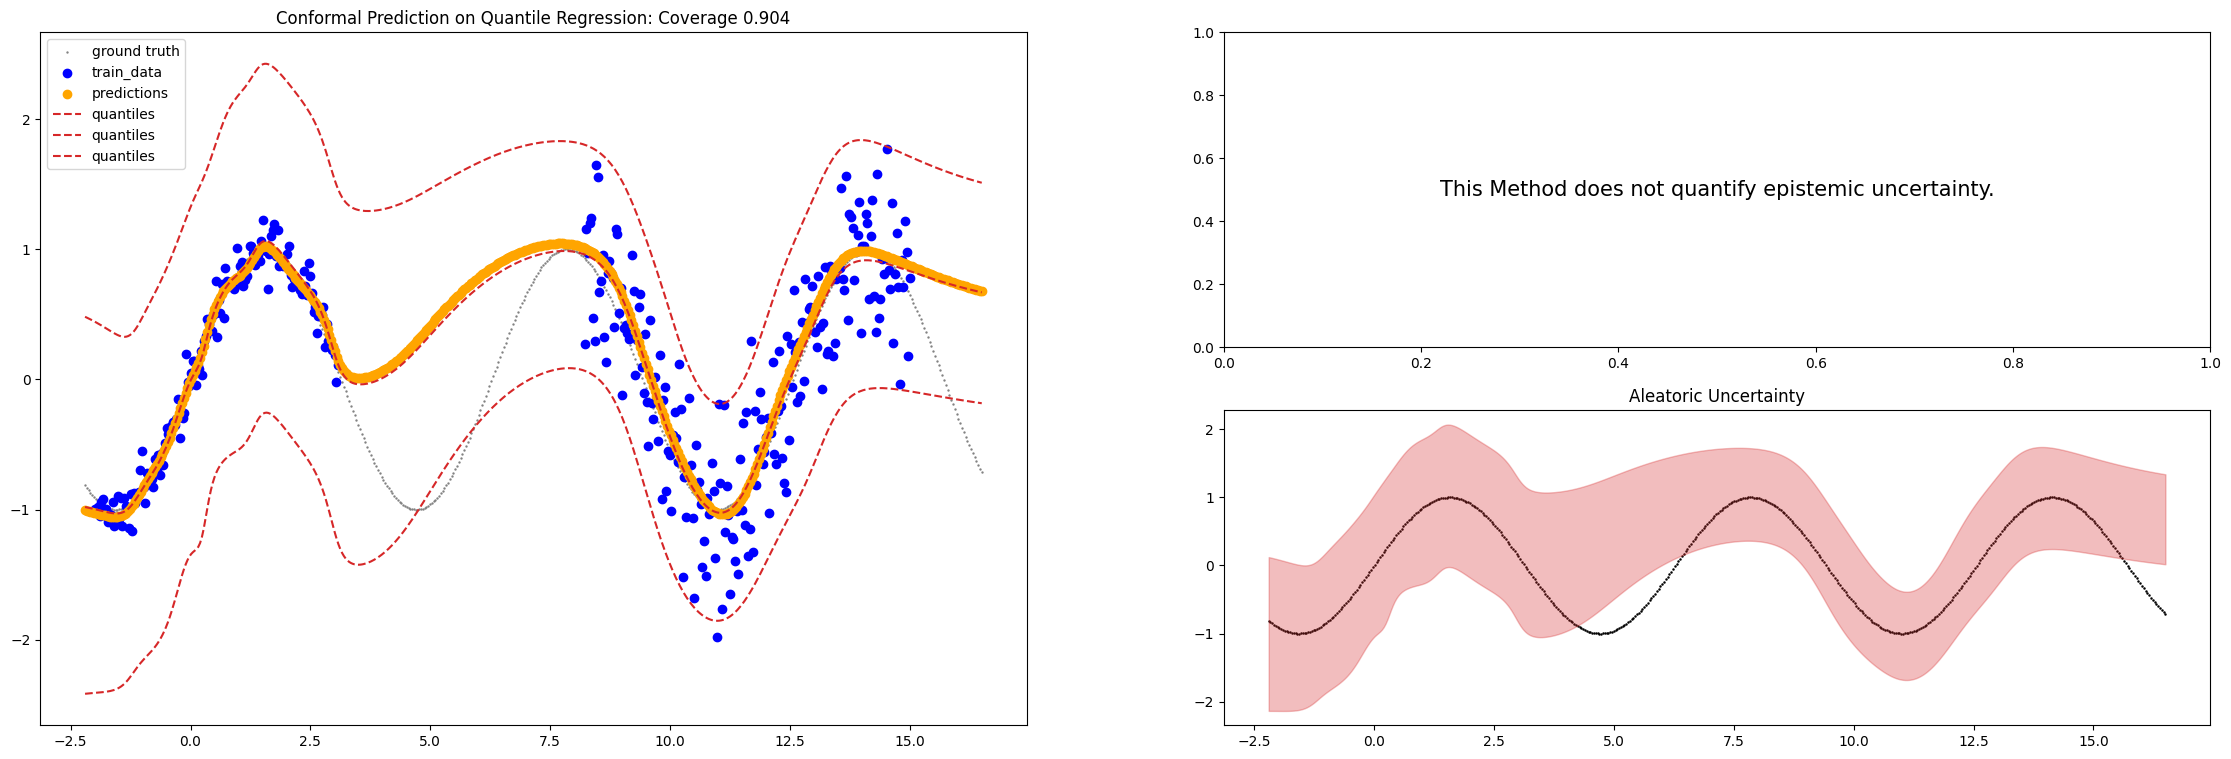

<Figure size 2800x900 with 0 Axes>

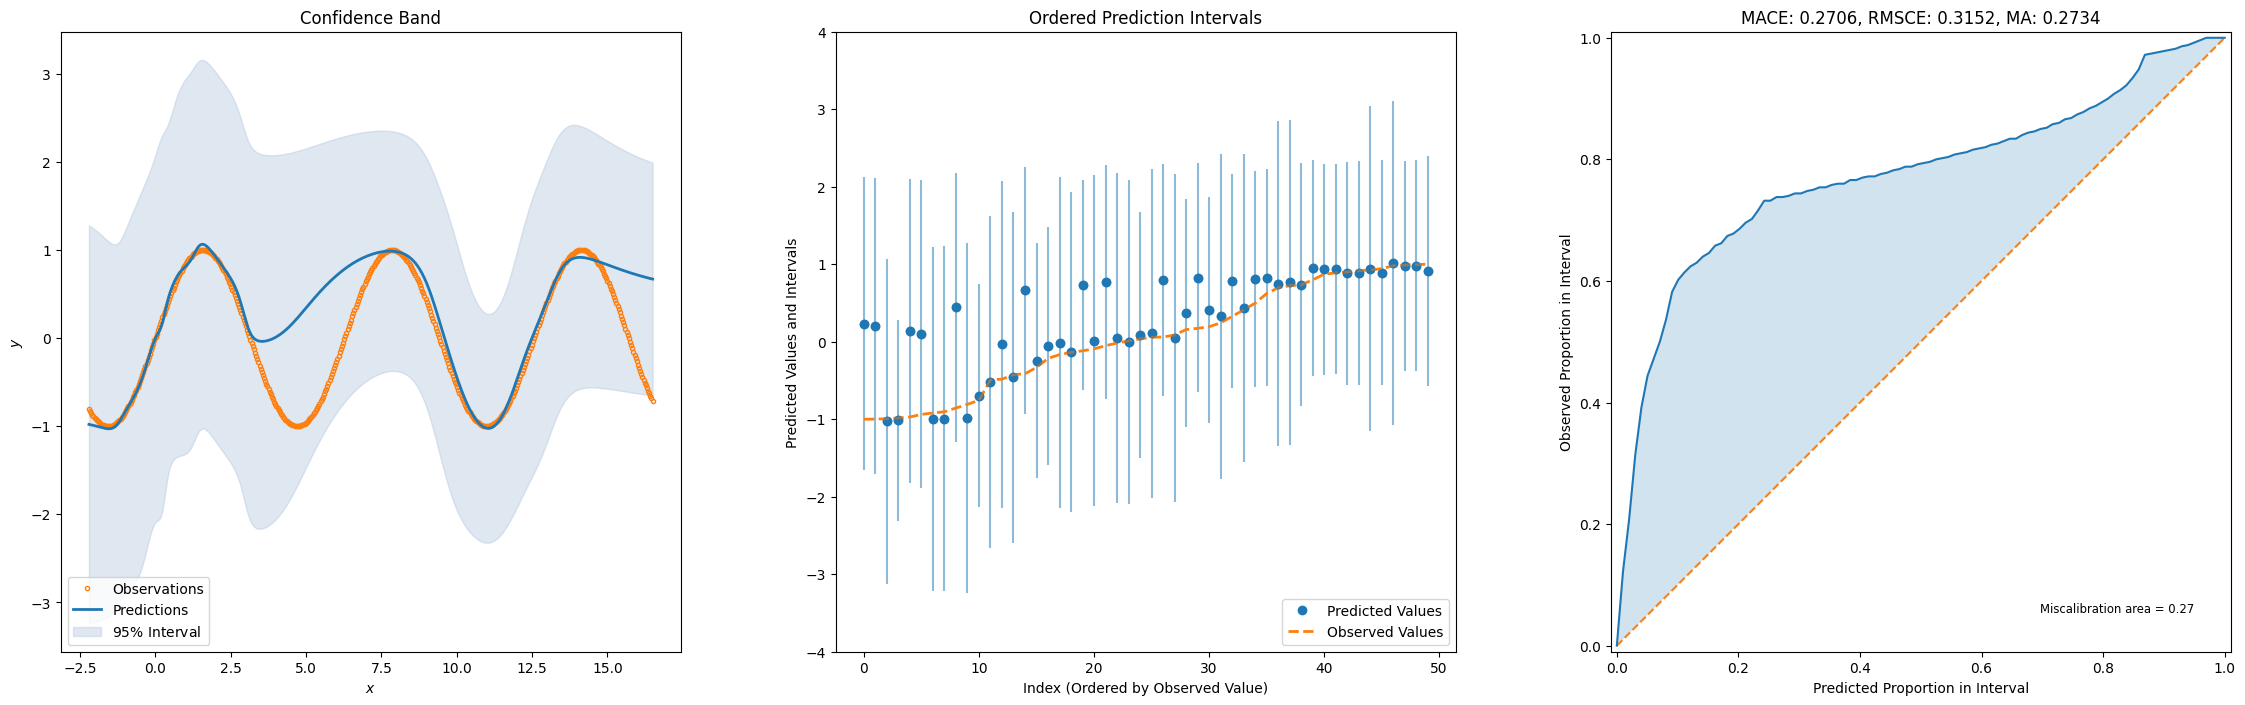

In [16]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    cqr_median,
    pred_quantiles=cqr_quantile_preds,
    aleatoric=cqr_aleatoric,
    title=f"Conformal Prediction on Quantile Regression: Coverage {compute_empirical_coverage(cqr_quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cqr_mean, cqr_std, y_test_cpu, X_test_cpu)

# Laplace Approximation

In [39]:
laplace_args = {
    "prior_mean": 0,
    "prior_precision": 1,
    "subset_of_weights": "all",
    "hessian_structure": "full",
}
laplace = LaplaceModel(base_model.model.net, train_loader, **laplace_args)

la_out = laplace.predict_step(X_test)
la_mean = la_out["mean"]
la_predictive = la_out["pred_uct"]
la_epistemic = la_out["epistemic_uct"]
la_aleatoric = la_out["aleatoric_uct"]

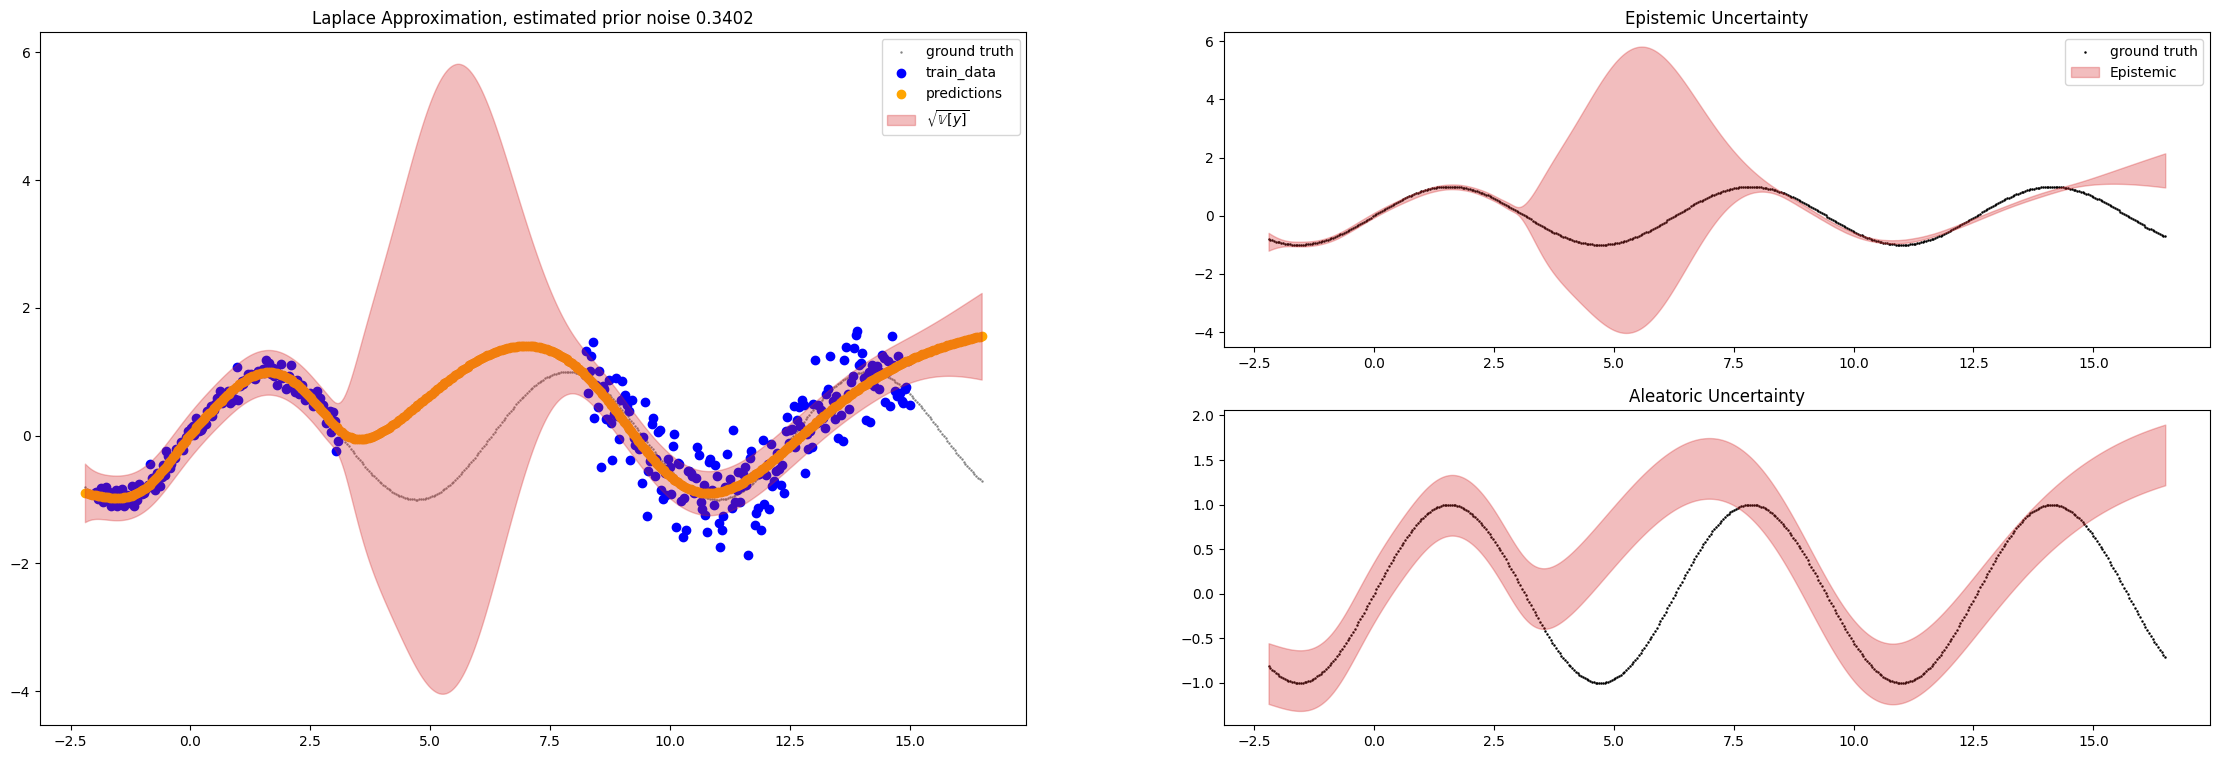

<Figure size 2800x900 with 0 Axes>

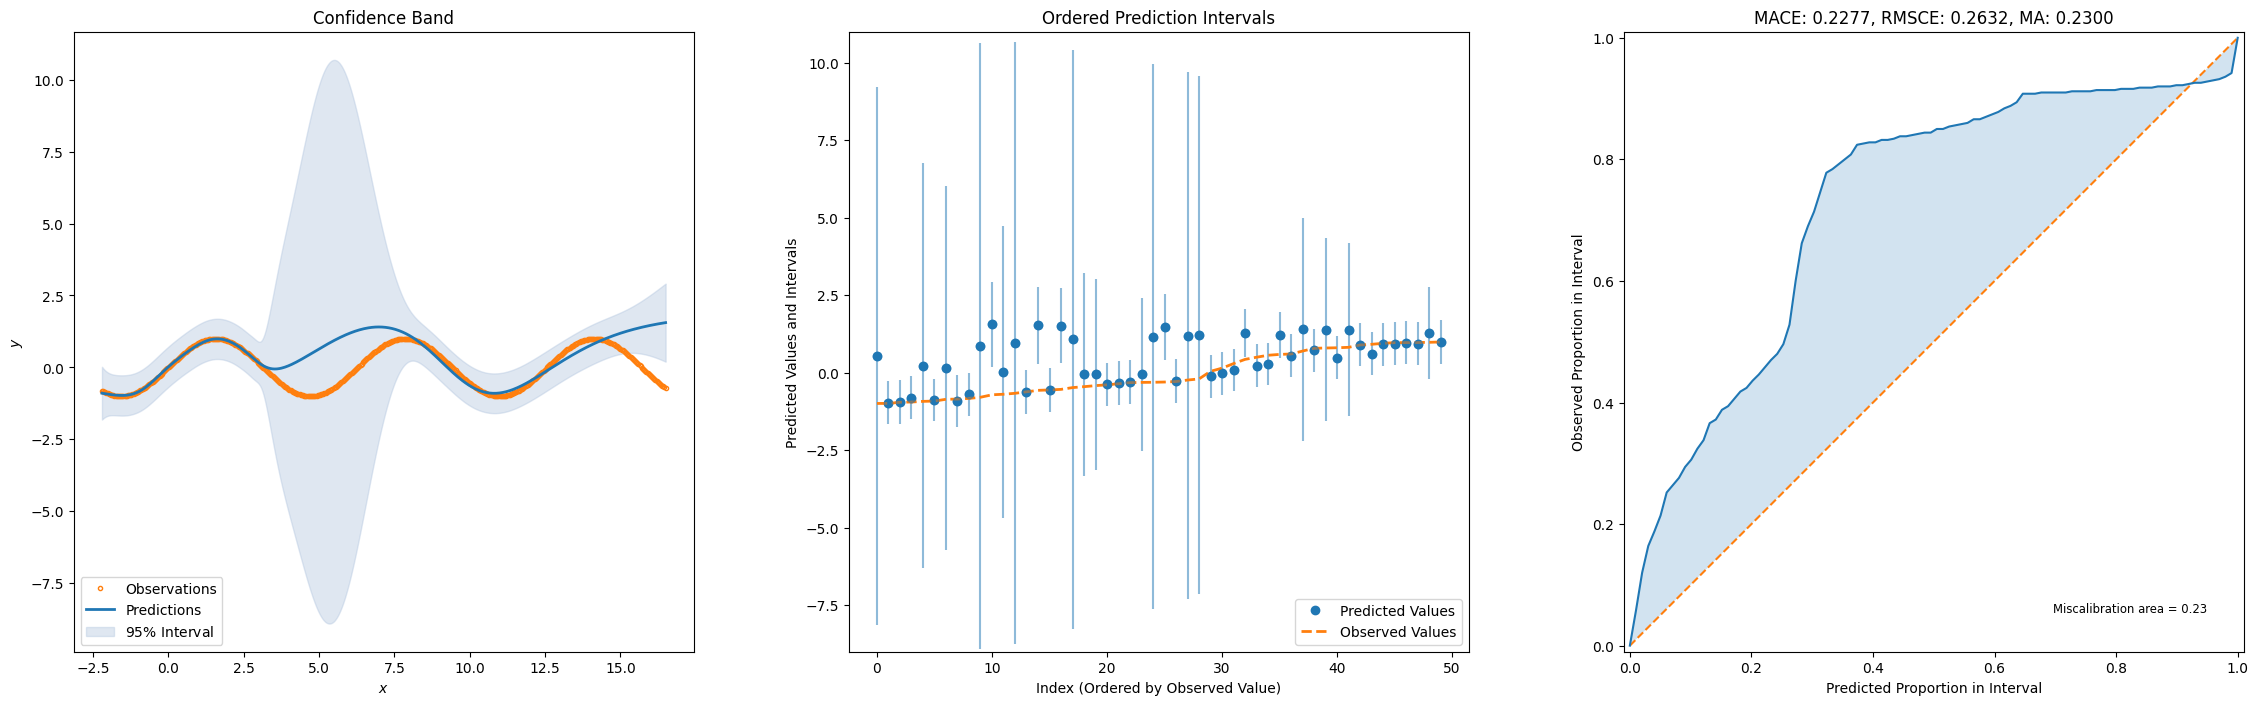

In [40]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    la_mean,
    la_predictive,
    epistemic=la_epistemic,
    aleatoric=la_aleatoric,
    title=f"Laplace Approximation, estimated prior noise {la_aleatoric:.4f}",
)
plot_calibration_uq_toolbox(la_mean, la_predictive, y_test_cpu, X_test_cpu)

# Deep Ensemble

## MSE

In [10]:
n_ensembles = 5
trained_models = []
for i in range(n_ensembles):
    ensemble_member = BaseModel(config, MLP())
    trained_models.append(
        basic_train_loop(ensemble_member, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=1000)
    )

100%|██████████| 1000/1000 [00:05<00:00, 171.08it/s, loss=0.09719408303499222]


In [20]:
# get predictions with ensemble wrapper
deep_ens = DeepEnsembleModel(None, trained_models)
with torch.no_grad():
    out = deep_ens.predict_step(X_test, y_test)
    mse_de_mean = out["mean"]
    mse_de_std = out["pred_uct"]
    de_epistemic_mse = out["epistemic_uct"]

In [21]:
for key, item in out.items(): print(key, item.shape)

mean (500,)
pred_uct (500,)
epistemic_uct (500,)


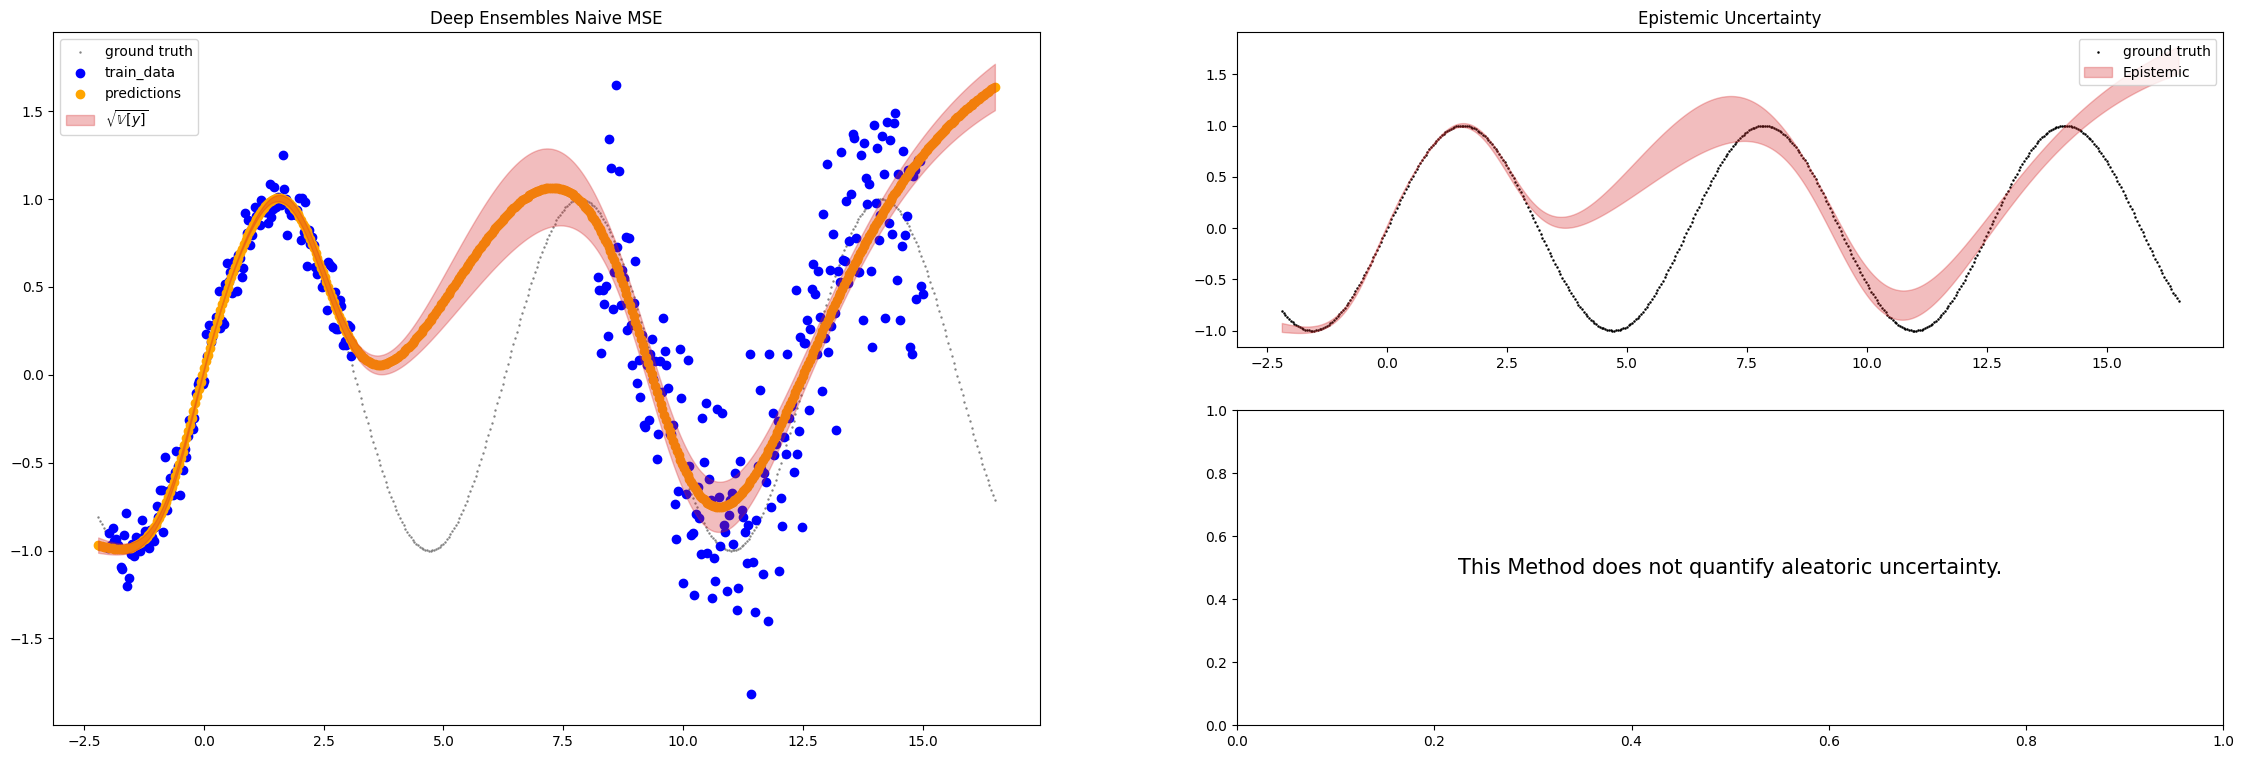

<Figure size 2800x900 with 0 Axes>

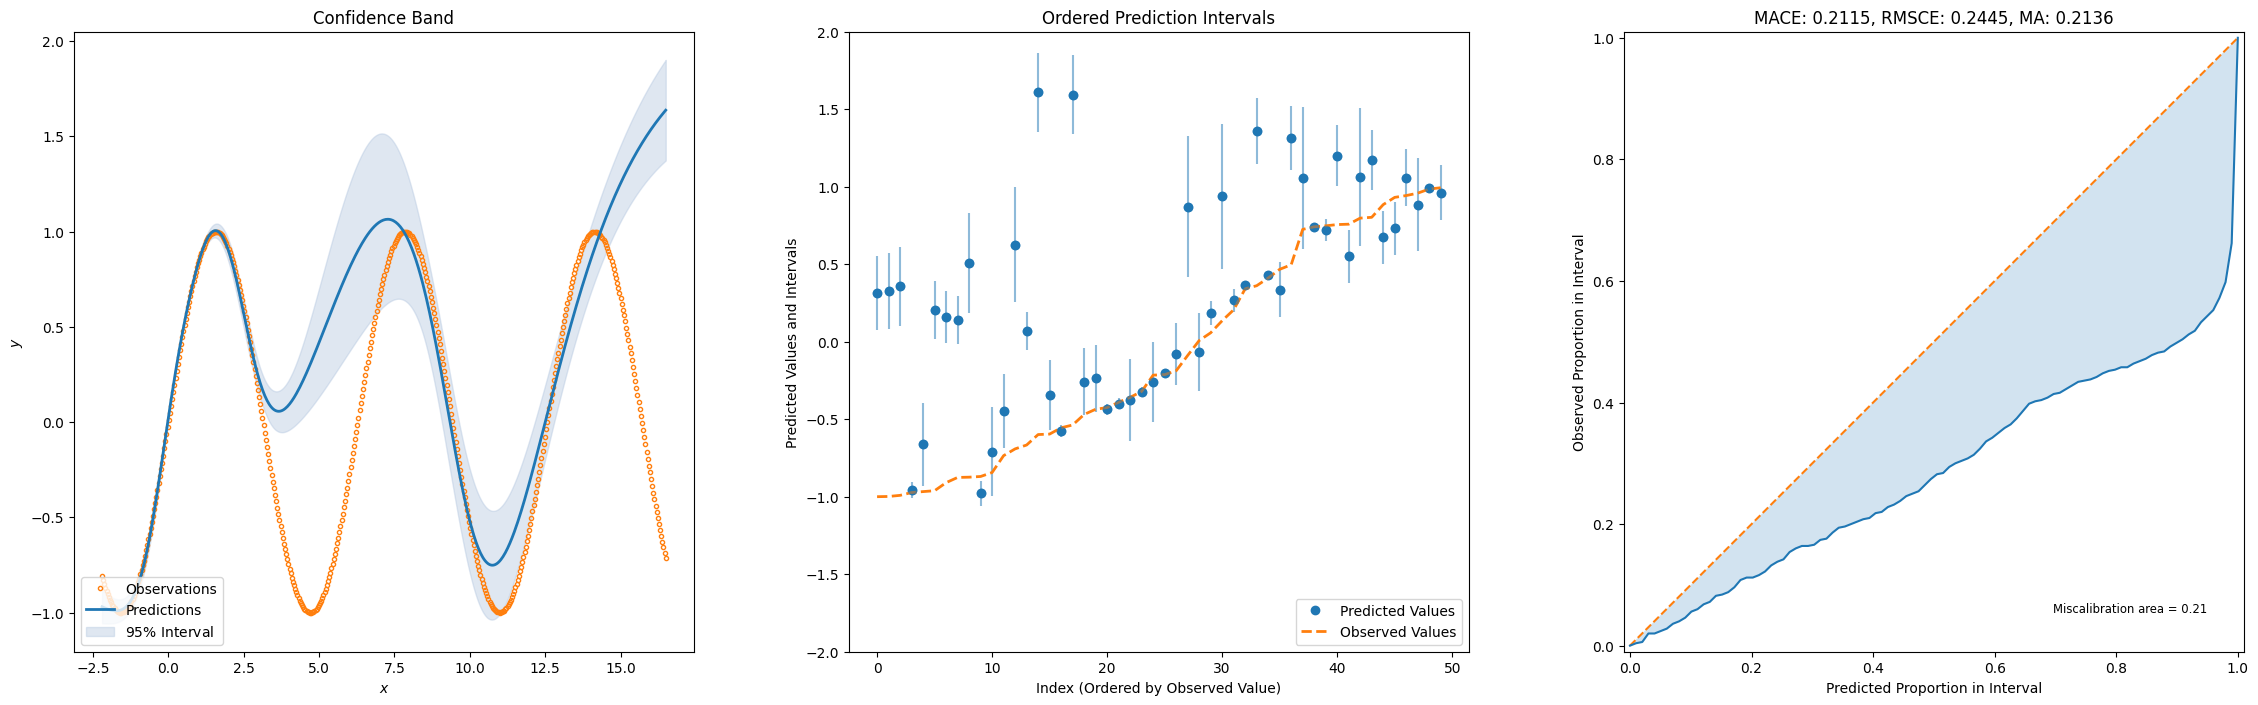

In [22]:
plot_predictions(
    X_train, y_train, X_test_cpu, y_test_cpu, mse_de_mean, mse_de_std, epistemic=mse_de_std, title="Deep Ensembles Naive MSE"
)
plot_calibration_uq_toolbox(mse_de_mean, mse_de_std, y_test_cpu, X_test_cpu)

## NLL

In [26]:
n_ensembles = 5
trained_models = []
for i in range(n_ensembles):
    ensemble_member = BaseModel(config, MLP(n_outputs=2, n_hidden=[50, 50, 50], predict_sigma=True))
    trained_models.append(
        basic_train_loop(ensemble_member, NLL(), train_loader, lr=1e-2, n_epochs=1500)
    )

100%|██████████| 1500/1500 [00:15<00:00, 96.65it/s, loss=-2.3722105026245117] 


In [27]:
# get predictions with ensemble wrapper
deep_ens_nll = DeepEnsembleModel(None, trained_models)
with torch.no_grad():
    out = deep_ens_nll.predict_step(X_test, y_test)
    nll_de_mean = out["mean"]
    nll_de_std = out["pred_uct"]
    nll_epistemic_de = out["epistemic_uct"]
    nll_aleatoric_de = out["aleatoric_uct"]

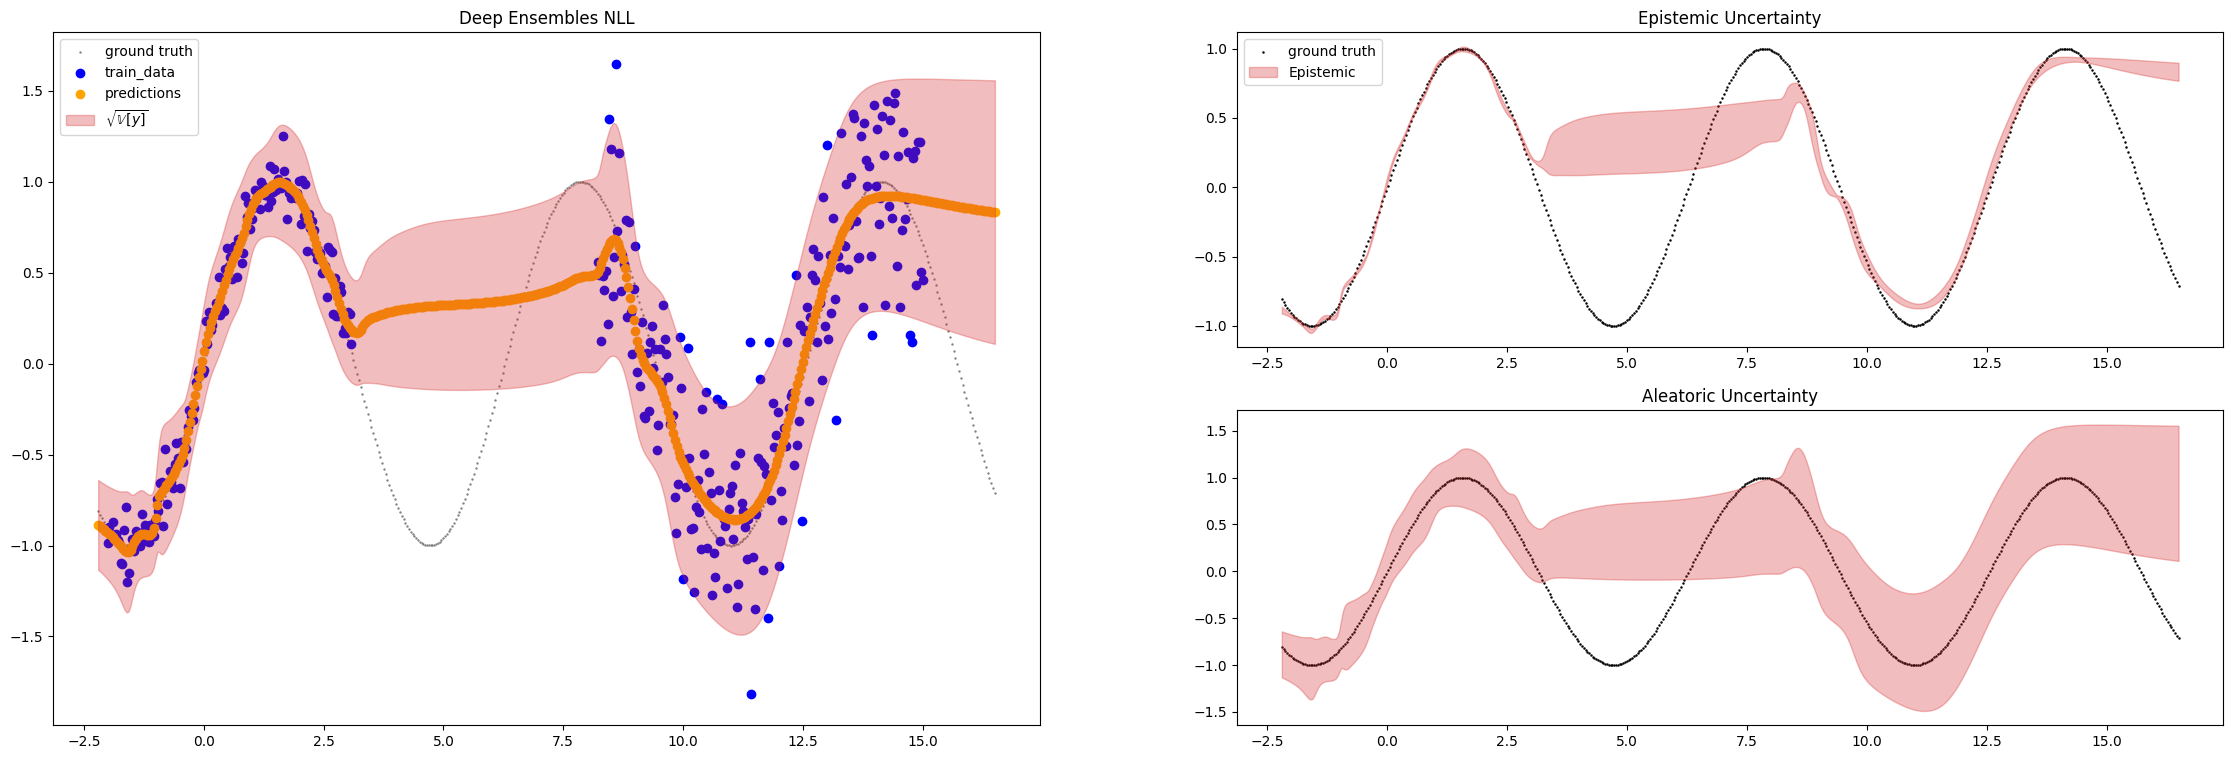

<Figure size 2800x900 with 0 Axes>

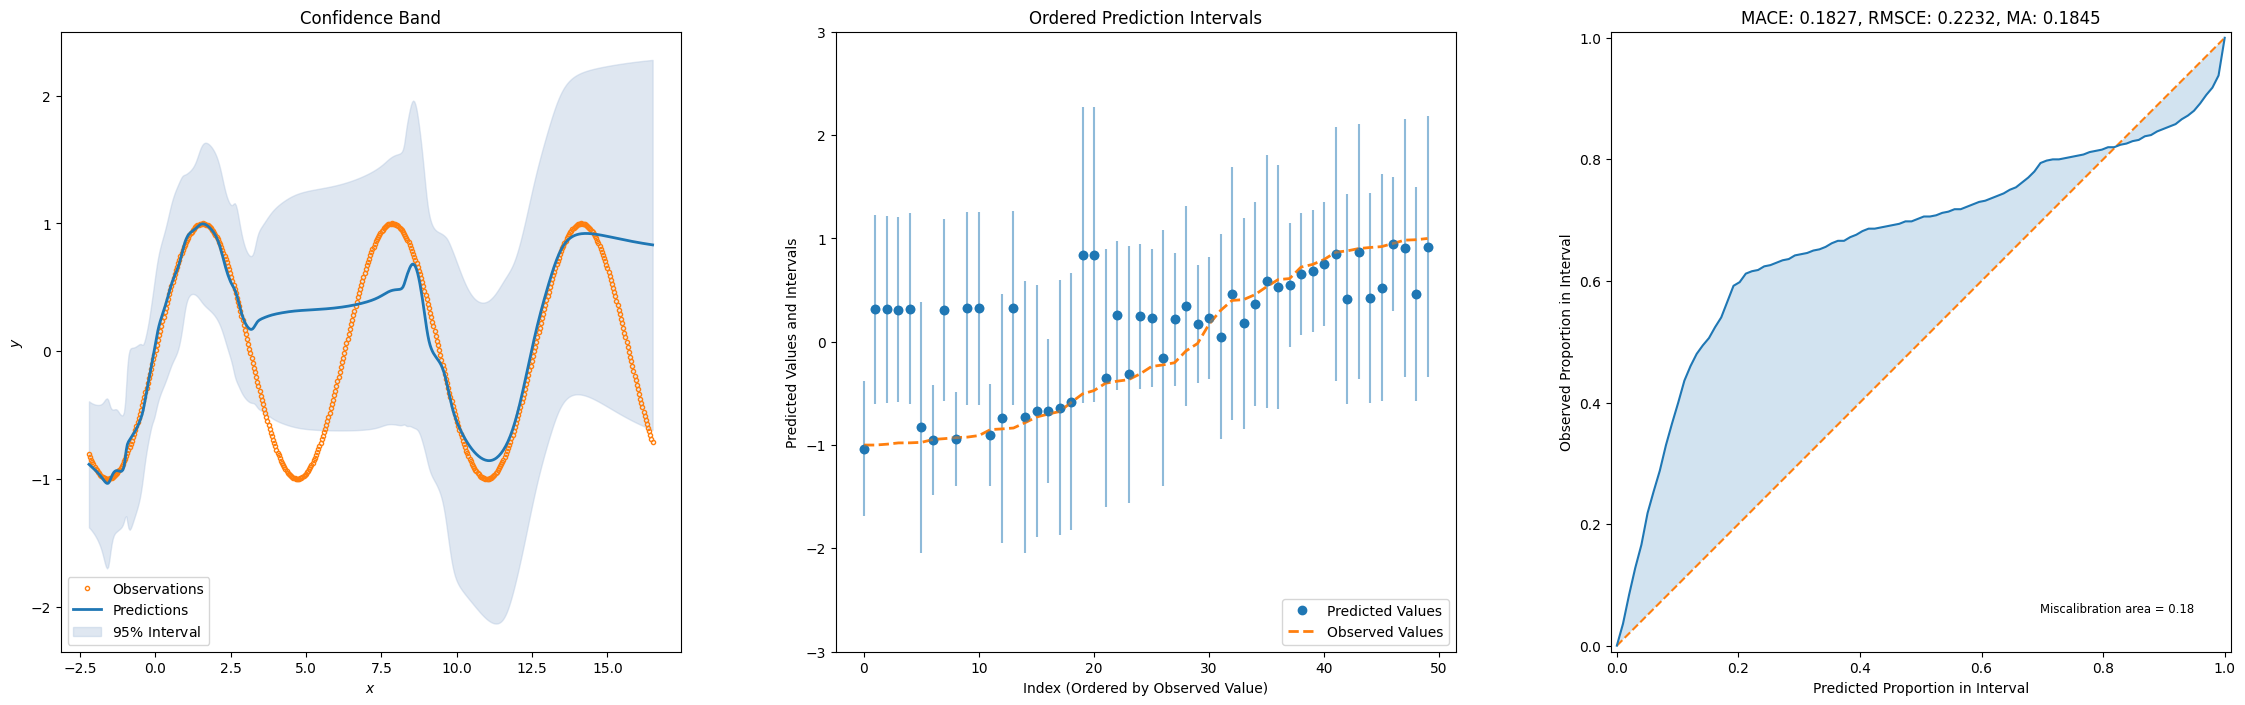

In [28]:
plot_predictions(
    X_train, y_train, X_test_cpu, y_test_cpu, nll_de_mean, nll_de_std, epistemic=nll_epistemic_de, aleatoric=nll_aleatoric_de, title="Deep Ensembles NLL"
)
plot_calibration_uq_toolbox(nll_de_mean, nll_de_std, y_test_cpu, X_test_cpu)